# Analysis of Results of the Inverse Model

In [1]:
import numpy as np
import Pk_library as PKL
import matplotlib.pyplot as plt
import sys
import os

In [6]:
# To prevent unnecessary printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [7]:
def get_plots_lin(dir_path, box_length = 250, axis = 0):
    """
    Function to plot the power spectrum vs wave-number,
    fractional error in transfer function (T(k)-1), and
    stochasticty (1-r^2(k))
    
    Inputs:
    dir_path: path of the directory containing the subdirectories with samples
    box_length: length of the box in Mpc/h
    axis: axis for which to calcuate the power spectrum (0->x-axis, 1-> y-axis, 2-> z-axis)
    
    The subdirectories within dir_path folder must have the files lin.npy,
    the original linear field and lin_inv_model.npy, i.e., the linear field predicted
    by the inverse model.
    """
    lin_auto_spectrums = []
    lin_inv_auto_spectrums = []
    cross_auto_spectrums = []
    tf_errs = []
    stocs = []
    dis_auto_spectrums = []
    
    wave_num = None
    
    #we only have the linear inverse field for 1st 50 directories in case of train
    if "train" in dir_path:
        sub_directories = [str(i) for i in range(1,51)]
    else:
        sub_directories = next(os.walk(dir_path))[1]
    
    
    for sub_dir in sub_directories:
        lin = np.load(f"{dir_path}{sub_dir}/lin.npy") # lin displacement field
        lin_inv_model = np.load(f"{dir_path}{sub_dir}/lin_inv_model.npy") # lin diplacement field predicted by inv model
        
        dis = np.load(f"{dir_path}{sub_dir}/dis.npy") #  displacement field
        
        with HiddenPrints():
            xpk  = PKL.XPk((lin_inv_model[axis], lin[axis]), box_length, 0, (None, None))
            dis_pk = PKL.XPk((lin_inv_model[axis], dis[axis]), box_length, 0, (None, None))
        
        if wave_num is None:
            wave_num = xpk.k3D

        lin_inv_model_auto = xpk.Pk[:,0,0] #auto ps of predicted field
        lin_auto = xpk.Pk[:,0,1] #auto ps of original field
        cross = xpk.XPk[:,0][:,0] #cross ps
        
        dis_auto = dis_pk.Pk[:,0,1]

        tf_err = np.sqrt(lin_inv_model_auto/lin_auto) - 1 #fractional error in transfer function
        stoc = 1 - (cross/np.sqrt(lin_inv_model_auto*lin_auto))**2 #stochastoicity
        
        lin_auto_spectrums.append(lin_auto)
        lin_inv_auto_spectrums.append(lin_inv_model_auto)
        cross_auto_spectrums.append(cross)
        dis_auto_spectrums.append(dis_auto)
        
        tf_errs.append(tf_err)
        stocs.append(stoc)
    
    lin_auto_specs = np.vstack(lin_auto_spectrums)
    lin_inv_auto_specs = np.vstack(lin_inv_auto_spectrums)
    cross_auto_specs = np.vstack(cross_auto_spectrums)
    dis_auto_spectrums = np.vstack(dis_auto_spectrums)
    
    tf_errs = np.vstack(tf_errs)
    stocs = np.vstack(stocs)
    
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    
    #plot the power spectrum of original and predicted field
    ax1.loglog(wave_num, np.mean(lin_auto_specs, axis=0), color = 'orange', label='Original Linear Field')
    ax1.loglog(wave_num, np.mean(lin_inv_auto_specs, axis=0), color = 'blue', label ='Generated Linear Field')
    
#     plt.loglog(wave_num, np.mean(dis_auto_spectrums, axis=0), color = 'red', label ='Displacement field')
    ax1.fill_between(wave_num, 
                     np.mean(lin_auto_specs, axis=0) - np.std(lin_auto_specs, axis=0), 
                     np.mean(lin_auto_specs, axis=0) + np.std(lin_auto_specs, axis=0),
                     alpha = 0.2,
                     color = 'orange')
    ax1.fill_between(wave_num, 
                     np.mean(lin_inv_auto_specs, axis=0) - np.std(lin_inv_auto_specs, axis=0), 
                     np.mean(lin_inv_auto_specs, axis=0) + np.std(lin_inv_auto_specs, axis=0),
                     alpha = 0.2,
                     color = 'blue')
    ax1.set_xlabel('k (log scale)')
    ax1.set_ylabel('P(k) (log scale)')
    ax1.legend()
    ax1.set_title("Power vs Wave Number")
    
    
    #plot the Transfer function fractional errors
    ax2.semilogx(wave_num, np.mean(tf_errs, axis=0), color = 'red')
#     print(np.mean(tf_errs, axis=0)[:10])
    ax2.fill_between(wave_num,
                     np.mean(tf_errs, axis=0) - np.std(tf_errs, axis=0),
                     np.mean(tf_errs, axis=0) + np.std(tf_errs, axis=0),
                     alpha = 0.2,
                     color='red')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Transfer function fractional errors')
    ax2.set_title('Transfer function fractional errors vs k')
    
    
    #plot the stochasticity
    ax3.semilogx(wave_num, np.mean(stocs, axis=0), color = 'green')
    ax3.fill_between(wave_num,
                     np.mean(stocs, axis=0) - np.std(stocs, axis=0),
                     np.mean(stocs, axis=0) + np.std(stocs, axis=0),
                     alpha = 0.2,
                     color='green')
    ax3.set_xlabel('k')
    ax3.set_ylabel('1 - (r(k)^2)')
    ax3.set_title('Stochasticty vs k')
    
    fig.tight_layout()
    plt.show()

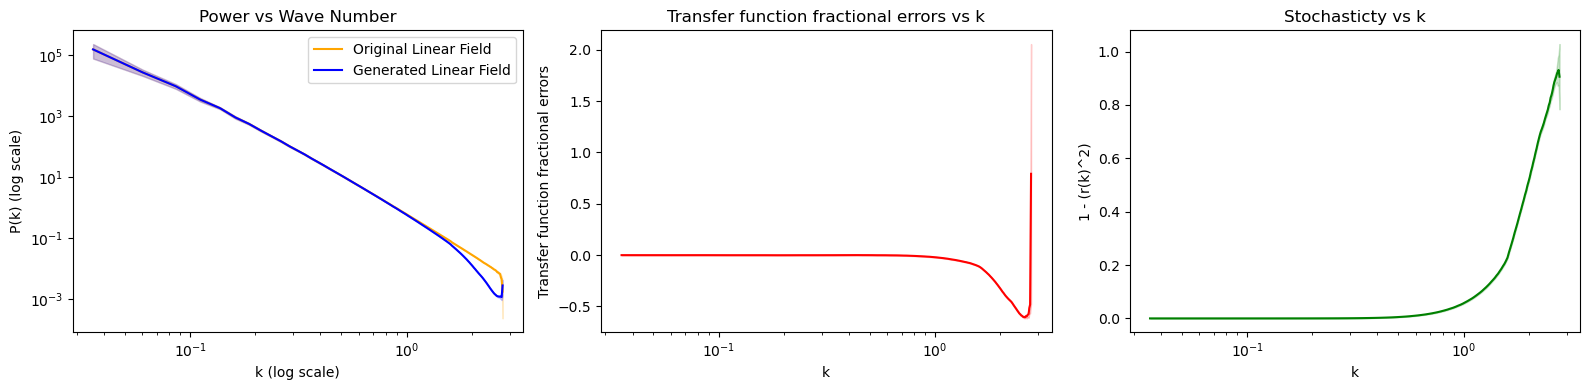

In [8]:
#plots for the test data (averaged over 78 test samples)
get_plots_lin("/user_data/vjindal/Mocks/N128/test/", box_length = (1e3/512 * 128), axis = 2)

## Plots for displacement and predicted displacement fields

In [23]:
def get_plots_dis(dir_path, box_length = 250, axis = 0):
    """
    Function to plot the power spectrum vs wave-number,
    fractional error in transfer function (T(k)-1), and
    stochasticty (1-r^2(k))
    
    Inputs:
    dir_path: path of the directory containing the subdirectories with samples
    box_length: length of the box in Mpc/h
    axis: axis for which to calcuate the power spectrum (0->x-axis, 1-> y-axis, 2-> z-axis)
    
    The subdirectories within dir_path folder must have the files dis.npy,
    the original displacement field and dis_for_lin_inv_model.npy, i.e., the disp field predicted
    by passing the output of inverse model through the forward model.
    """
    dis_auto_spectrums = []
    dis_for_lin_inv_auto_spectrums = []
    cross_auto_spectrums = []
    tf_errs = []
    stocs = []
    
    wave_num = None
    
    #we only have the linear inverse field for 1st 50 directories in case of train
    if "train" in dir_path:
        sub_directories = [str(i) for i in range(1,51)]
    else:
        sub_directories = next(os.walk(dir_path))[1]
    
    
    for sub_dir in sub_directories[4:5]:
        dis = np.load(f"{dir_path}{sub_dir}/dis.npy") # lin displacement field
        dis_for_lin_inv = np.load(f"{dir_path}{sub_dir}/dis_for_lin_inv_model.npy") # lin diplacement field predicted by inv model
        
        with HiddenPrints():
            xpk  = PKL.XPk((dis_for_lin_inv[axis], dis[axis]), box_length, 0, (None, None))
            
        if wave_num is None:
            wave_num = xpk.k3D

        dis_for_lin_inv_model_auto = xpk.Pk[:,0,0] #auto ps of predicted field
        dis_auto = xpk.Pk[:,0,1] #auto ps of original field
        cross = xpk.XPk[:,0][:,0] #cross ps
        
        tf_err = np.sqrt(dis_for_lin_inv_model_auto/dis_auto) - 1 #fractional error in transfer function
        stoc = 1 - (cross/np.sqrt(dis_for_lin_inv_model_auto*dis_auto))**2 #stochastoicity
        
        dis_auto_spectrums.append(dis_auto)
        dis_for_lin_inv_auto_spectrums.append(dis_for_lin_inv_model_auto)
        cross_auto_spectrums.append(cross)
        
        tf_errs.append(tf_err)
        stocs.append(stoc)
    
    dis_auto_specs = np.vstack(dis_auto_spectrums)
    dis_for_lin_inv_auto_specs = np.vstack(dis_for_lin_inv_auto_spectrums)
    cross_auto_specs = np.vstack(cross_auto_spectrums)
    
    tf_errs = np.vstack(tf_errs)
    stocs = np.vstack(stocs)
    
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    
    #plot the power spectrum of original and predicted field
    ax1.loglog(wave_num, np.mean(dis_auto_specs, axis=0), color = 'orange', label='Original Displacement Field')
    ax1.loglog(wave_num, np.mean(dis_for_lin_inv_auto_specs, axis=0), color = 'blue', label ='Disp generated from reconstructed lin')
    
    ax1.fill_between(wave_num, 
                     np.mean(dis_auto_specs, axis=0) - np.std(dis_auto_specs, axis=0), 
                     np.mean(dis_auto_specs, axis=0) + np.std(dis_auto_specs, axis=0),
                     alpha = 0.2,
                     color = 'orange')
    ax1.fill_between(wave_num, 
                     np.mean(dis_for_lin_inv_auto_specs, axis=0) - np.std(dis_for_lin_inv_auto_specs, axis=0), 
                     np.mean(dis_for_lin_inv_auto_specs, axis=0) + np.std(dis_for_lin_inv_auto_specs, axis=0),
                     alpha = 0.2,
                     color = 'blue')
    ax1.set_xlabel('k (log scale)')
    ax1.set_ylabel('P(k) (log scale)')
    ax1.legend()
    ax1.set_title("Power vs Wave Number")
    
    
    #plot the Transfer function fractional errors
    ax2.semilogx(wave_num, np.mean(tf_errs, axis=0), color = 'red')
    ax2.fill_between(wave_num,
                     np.mean(tf_errs, axis=0) - np.std(tf_errs, axis=0),
                     np.mean(tf_errs, axis=0) + np.std(tf_errs, axis=0),
                     alpha = 0.2,
                     color='red')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Transfer function fractional errors')
    ax2.set_title('Transfer function fractional errors vs k')
    
    
    #plot the stochasticity
    ax3.semilogx(wave_num, np.mean(stocs, axis=0), color = 'green')
    ax3.fill_between(wave_num,
                     np.mean(stocs, axis=0) - np.std(stocs, axis=0),
                     np.mean(stocs, axis=0) + np.std(stocs, axis=0),
                     alpha = 0.2,
                     color='green')
    ax3.set_xlabel('k')
    ax3.set_ylabel('1 - (r(k)^2)')
    ax3.set_title('Stochasticty vs k')
    
    fig.tight_layout()
    plt.show()

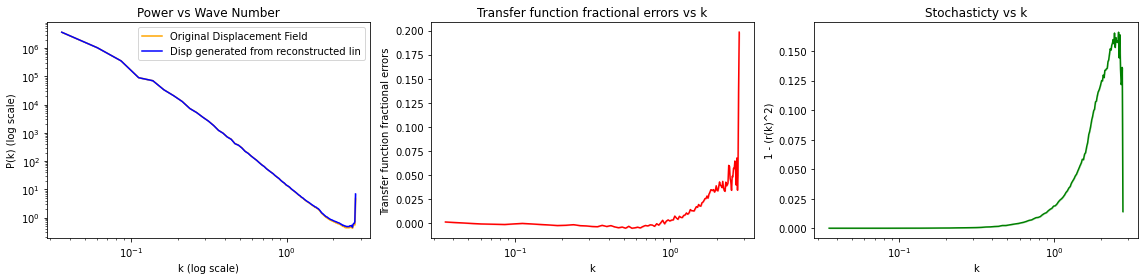

In [24]:
#plots for the test data (averaged over 78 test samples)
get_plots_dis("/user_data/vjindal/Mocks/N128/test/", box_length = (1e3/512 * 128), axis = 1)